# Counterfactual fairness

## Data

To evaluate _counterfactual fairness_ we will be using the "law school" dataset {cite}`mcintyre2018law`.

The Law School Admission Council conducted a survey across 163 law schools in the United States. 
It contains information on 21,790 law students such as their entrance exam scores (`LSAT`), their
grade-point average (`GPA`) collected prior to law school, and their first year average grade (`FYA`).
Given this data, a school may wish to predict if an applicant will have a high `FYA`. The school would
also like to make sure these predictions are not biased by an individual’s race and sex. 
However, the `LSAT`, `GPA`, and `FYA` scores, may be biased due to social factors.

We start by importing the data into a Pandas `DataFrame`.

In [1]:
import pandas as pd

df = pd.read_csv("data/law_data.csv", index_col=0)
df.head()

,race,sex,LSAT,UGPA,region_first,ZFYA,sander_index,first_pf
0,White,1,39.0,3.1,GL,-0.98,0.782738,1.0
1,White,1,36.0,3.0,GL,0.09,0.735714,1.0
2,White,2,30.0,3.1,MS,-0.35,0.670238,1.0
5,Hispanic,2,39.0,2.2,NE,0.58,0.697024,1.0
6,White,1,37.0,3.4,GL,-1.26,0.786310,1.0


### Pre-processing

We now pre-process the data. We start by creating categorical "dummy" variables according to the `race` variable.

In [2]:
df = pd.get_dummies(df, columns=["race"], prefix="", prefix_sep="")
df.head()

,sex,LSAT,UGPA,region_first,ZFYA,sander_index,first_pf,Amerindian,Asian,Black,Hispanic,Mexican,Other,Puertorican,White
0,1,39.0,3.1,GL,-0.98,0.782738,1.0,0,0,0,0,0,0,0,1
1,1,36.0,3.0,GL,0.09,0.735714,1.0,0,0,0,0,0,0,0,1
2,2,30.0,3.1,MS,-0.35,0.670238,1.0,0,0,0,0,0,0,0,1
5,2,39.0,2.2,NE,0.58,0.697024,1.0,0,0,0,1,0,0,0,0
6,1,37.0,3.4,GL,-1.26,0.786310,1.0,0,0,0,0,0,0,0,1


We also want to expand the `sex` variable into `male`/`female` categorical variables and remove the original.

In [3]:
df["male"] = df["sex"].map(lambda x: 1 if x == 2 else 0)
df["female"] = df["sex"].map(lambda x: 1 if x == 1 else 0)
df = df.drop(axis=1, columns=["sex"])
df.head()

,LSAT,UGPA,region_first,ZFYA,sander_index,first_pf,Amerindian,Asian,Black,Hispanic,Mexican,Other,Puertorican,White,male,female
0,39.0,3.1,GL,-0.98,0.782738,1.0,0,0,0,0,0,0,0,1,0,1
1,36.0,3.0,GL,0.09,0.735714,1.0,0,0,0,0,0,0,0,1,0,1
2,30.0,3.1,MS,-0.35,0.670238,1.0,0,0,0,0,0,0,0,1,1,0
5,39.0,2.2,NE,0.58,0.697024,1.0,0,0,0,1,0,0,0,0,1,0
6,37.0,3.4,GL,-1.26,0.786310,1.0,0,0,0,0,0,0,0,1,0,1


We will also convert the entrance exam scores (`LSAT`) to a discrete variable.

In [4]:
df["LSAT"] = df["LSAT"].astype(int)
df.head()

,LSAT,UGPA,region_first,ZFYA,sander_index,first_pf,Amerindian,Asian,Black,Hispanic,Mexican,Other,Puertorican,White,male,female
0,39,3.1,GL,-0.98,0.782738,1.0,0,0,0,0,0,0,0,1,0,1
1,36,3.0,GL,0.09,0.735714,1.0,0,0,0,0,0,0,0,1,0,1
2,30,3.1,MS,-0.35,0.670238,1.0,0,0,0,0,0,0,0,1,1,0
5,39,2.2,NE,0.58,0.697024,1.0,0,0,0,1,0,0,0,0,1,0
6,37,3.4,GL,-1.26,0.786310,1.0,0,0,0,0,0,0,0,1,0,1


### Protected attributes

_Counterfactual fairness_ enforces that a distribution over possible predictions for an individual should
remain unchanged in a world where an individual’s protected attributes $A$ had been different in a causal sense

Let's start by defining the _protected attributes_. Obvious candidates are the different categorical variables for ethnicity (`Asian`, `White`, `Black`, _etc_) and gender (`male`, `female`).

In [5]:
A = [
    "Amerindian",
    "Asian",
    "Black",
    "Hispanic",
    "Mexican",
    "Other",
    "Puertorican",
    "White",
    "male",
    "female",
]

### Training and testing subsets

We will now divide the dataset into training and testing subsets.
We will use the same ratio as in {cite}`Kusner2017`, that is 20%.

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=23, test_size=0.2);

## Unfair model

As detailed in {cite}`Kusner2017`, the concept of counterfactual fairness holds
under three levels of assumptions of increasing strength.

The first of such levels is **Level 1**, where $\hat{Y}$ is built using only the observable non-descendants of $A$. 
This only requires **partial** causal ordering and no further causal assumptions, but in many problems there will be few, if any,
observables which are not descendants of protected demographic factors.

For this dataset, since `LSAT`, `GPA`, and `FYA` are all biased by ethnicity and gender, we cannot use any observed
features to construct a Level 1 counterfactually fair predictor as described in Level 1.

Instead (and in order to compare the performance with Level 2 and 3 models) we will build two _unfair baselines_.

* A **Full* model, which will be trained with the totality of the variables
* An **Unaware** model (FTU), which will be trained will all the variables, except the protected attributes $A$.

Let's proceed with calculating the **Full** model.

### Full model

As mentioned previously, the full model will be a simple linear regression in order to predict `ZFYA` using all of the variables.

In [7]:
from sklearn.linear_model import LinearRegression

linreg_unfair = LinearRegression()

The inputs will then be the totality of the variabes (protected variables $A$, as well as `UGPA` and `LSAT`).

In [9]:
import numpy as np

X = np.hstack(
    (
        df_train[A],
        np.array(df_train["UGPA"]).reshape(-1, 1),
        np.array(df_train["LSAT"]).reshape(-1, 1),
    )
)
print(X)

[[ 0.   0.   0.  ...  1.   3.1 39. ]
 [ 0.   0.   0.  ...  1.   3.5 36. ]
 [ 0.   0.   0.  ...  1.   3.9 46. ]
 ...
 [ 0.   0.   0.  ...  1.   2.9 33. ]
 [ 0.   0.   0.  ...  0.   2.9 31. ]
 [ 0.   0.   0.  ...  0.   3.6 39. ]]


As for our target, we are trying to predict `ZFYA` (first year average grade).

In [10]:
y = df_train["ZFYA"]
y[:10]

10454    0.56
14108    0.60
20624   -0.14
8316     0.20
14250    0.02
18909   -1.47
8949     1.36
1658     0.39
23340    0.10
26884    0.48
Name: ZFYA, dtype: float64

We fit the model:

In [11]:
linreg_unfair = linreg_unfair.fit(X, y)

And perform some predictions on the test subset.

In [12]:
X_test = np.hstack(
    (
        df_test[A],
        np.array(df_test["UGPA"]).reshape(-1, 1),
        np.array(df_test["LSAT"]).reshape(-1, 1),
    )
)
X_test

array([[ 0. ,  0. ,  0. , ...,  0. ,  3.4, 32. ],
       [ 0. ,  0. ,  0. , ...,  1. ,  3.5, 41. ],
       [ 0. ,  0. ,  0. , ...,  1. ,  3.9, 42. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  2.3, 28. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  3.3, 36. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  2.9, 37. ]])

In [13]:
predictions_unfair = linreg_unfair.predict(X_test)
predictions_unfair

array([ 0.08676147,  0.34942627,  0.4609375 , ..., -0.25949097,
        0.19308472,  0.14471436])

We will also calculate the _unfair model_ score for future use.

In [14]:
score_unfair = linreg_unfair.score(X_test, df_test["ZFYA"])
print(score_unfair)

0.12701634112845117


In [16]:
from sklearn.metrics import mean_squared_error

RMSE_unfair = np.sqrt(mean_squared_error(df_test["ZFYA"], predictions_unfair))
print(RMSE_unfair)

0.8666709890234552


## Fairness through unawareness (FTU)

As also mentioned in {cite}`Kusner2017`, the second baseline we will use is an **Unaware** model (FTU), which will be trained will all the variables, except the protected attributes $A$.

In [17]:
linreg_ftu = LinearRegression()

We will create the inputs as previously, but without using the protected attributes, $A$.

In [18]:
X_ftu = np.hstack(
    (
        np.array(df_train["UGPA"]).reshape(-1, 1),
        np.array(df_train["LSAT"]).reshape(-1, 1),
    )
)
X_ftu

array([[ 3.1, 39. ],
       [ 3.5, 36. ],
       [ 3.9, 46. ],
       ...,
       [ 2.9, 33. ],
       [ 2.9, 31. ],
       [ 3.6, 39. ]])

And we fit the model:

In [19]:
linreg_ftu = linreg_ftu.fit(X_ftu, y)

Again, let's perform some predictions on the test subset.

In [20]:
X_ftu_test = np.hstack(
    (np.array(df_test["UGPA"]).reshape(-1, 1), np.array(df_test["LSAT"]).reshape(-1, 1))
)
X_ftu_test

array([[ 3.4, 32. ],
       [ 3.5, 41. ],
       [ 3.9, 42. ],
       ...,
       [ 2.3, 28. ],
       [ 3.3, 36. ],
       [ 2.9, 37. ]])

In [21]:
predictions_ftu = linreg_ftu.predict(X_ftu_test)
predictions_ftu

array([-0.06909331,  0.35516229,  0.50304555, ..., -0.53109868,
        0.08204563,  0.0226846 ])

As previously, let's calculate this model's score.

In [22]:
ftu_score = linreg_ftu.score(X_ftu_test, df_test["ZFYA"])
print(ftu_score)

0.0917442226187073


In [23]:
RMSE_ftu = np.sqrt(mean_squared_error(df_test["ZFYA"], predictions_ftu))
print(RMSE_ftu)

0.8840061503773576


## Latent variable model

Still according to {cite}`Kusner2017`, a **Level 2** approach will model latent ‘fair’ variables which are parents of observed variables.

If we consider a predictor parameterised by $\theta$, such as:

$$
\hat{Y} \equiv g_\theta (U, X_{\nsucc A})
$$

with $X_{\nsucc A} \subseteq X$ are non-descendants of $A$.
Assuming a loss function $l(\cdot,\cdot)$ and training data $\mathcal{D}\equiv\{(A^{(i), X^{(i)}, Y^{(i)}})\}$, for $i=1,2\dots,n$, the empirical loss is defined as

$$
L(\theta)\equiv \sum_{i=1}^n \mathbb{E}[l(y^{(i)},g_\theta(U^{(i)}, x^{(i)}_{\nsucc A}))]/n
$$

which has to be minimised in order to $\theta$. Each $n$ expectation is with respect to random variable $U^{(i)}$ such that

$$
U^{(i)}\sim P_{\mathcal{M}}(U|x^{(i)}, a^{(i)})
$$

where $P_{\mathcal{M}}(U|x,a)$ is the conditional distribution of the background variables as given by a causal model M that is available by assumption.

If this expectation cannot be calculated analytically, Markov chain Monte Carlo (MCMC) can be used to approximate it as in the following algorithm.

We will follow the model specified in the original paper, where the latent variable considered is $K$, which represents a student's **knowledge**.
$K$ will affect `GPA`, `LSAT` and the outcome, `FYA`.
The model can be defined by:

$$
GPA \sim \mathcal{N}(GPA_0 + w_{GPA}^KK + w_{GPA}^RR + w_{GPA}^SS, \sigma_{GPA}) \\
LSAT \sim \text{Po}(\exp(LSAT_0 + w_{LSAT}^KK + w_{LSAT}^RR + w_L^SS)) \\
FYA \sim \mathcal{N}(w_{FYA}^KK + w_{FYA}^RR + w_{FYA}^SS, 1) \\
K \sim \mathcal{N}(0,1)
$$

The priors used will be:

$$
GPA_0 \sim \mathcal{N}(0, 1) \\
LSAT_0 \sim \mathcal{N}(0, 1) \\
GPA_0 \sim \mathcal{N}(0, 1) \\
$$

In [27]:
import pymc3 as pm

K = len(A)


def MCMC(data, samples=1000):

    N = len(data)
    a = np.array(data[A])

    model = pm.Model()

    with model:
        # Priors
        k = pm.Normal("k", mu=0, sigma=1, shape=(1, N))
        gpa0 = pm.Normal("gpa0", mu=0, sigma=1)
        lsat0 = pm.Normal("lsat0", mu=0, sigma=1)
        w_k_gpa = pm.Normal("w_k_gpa", mu=0, sigma=1)
        w_k_lsat = pm.Normal("w_k_lsat", mu=0, sigma=1)
        w_k_zfya = pm.Normal("w_k_zfya", mu=0, sigma=1)

        w_a_gpa = pm.Normal("w_a_gpa", mu=np.zeros(K), sigma=np.ones(K), shape=K)
        w_a_lsat = pm.Normal("w_a_lsat", mu=np.zeros(K), sigma=np.ones(K), shape=K)
        w_a_zfya = pm.Normal("w_a_zfya", mu=np.zeros(K), sigma=np.ones(K), shape=K)

        sigma_gpa_2 = pm.InverseGamma("sigma_gpa_2", alpha=1, beta=1)

        mu = gpa0 + (w_k_gpa * k) + pm.math.dot(a, w_a_gpa)

        # Observed data
        gpa = pm.Normal(
            "gpa",
            mu=mu,
            sigma=pm.math.sqrt(sigma_gpa_2),
            observed=list(data["UGPA"]),
            shape=(1, N),
        )
        lsat = pm.Poisson(
            "lsat",
            pm.math.exp(lsat0 + w_k_lsat * k + pm.math.dot(a, w_a_lsat)),
            observed=list(data["LSAT"]),
            shape=(1, N),
        )
        zfya = pm.Normal(
            "zfya",
            mu=w_k_zfya * k + pm.math.dot(a, w_a_zfya),
            sigma=1,
            observed=list(data["ZFYA"]),
            shape=(1, N),
        )

        step = pm.Metropolis()
        trace = pm.sample(samples, step)

    return trace

In [28]:
train_estimates = MCMC(df_train)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_gpa_2]
>Metropolis: [w_a_zfya]
>Metropolis: [w_a_lsat]
>Metropolis: [w_a_gpa]
>Metropolis: [w_k_zfya]
>Metropolis: [w_k_lsat]
>Metropolis: [w_k_gpa]
>Metropolis: [lsat0]
>Metropolis: [gpa0]
>Metropolis: [k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Let's plot a single trace for $k^{(i)}$.

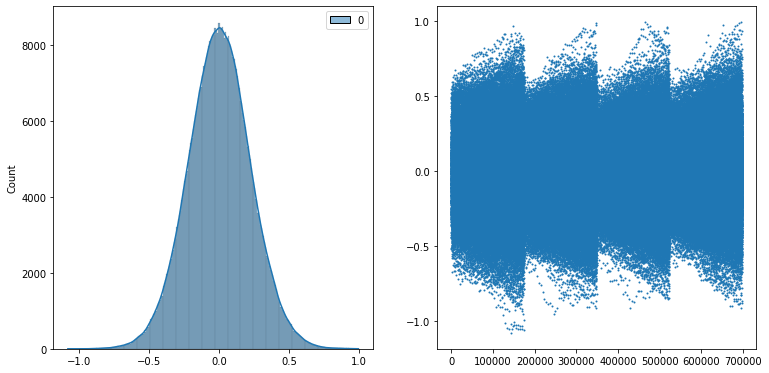

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotutils import *

# Thin the samples before plotting
k_trace = train_estimates["k"][:, 0].reshape(-1, 1)[0::100]
plt.subplot(1, 2, 1)
sns.histplot(k_trace, kde=True)
plt.subplot(1, 2, 2)
plt.scatter(range(len(k_trace)), k_trace, s=1)
plt.show()

In [33]:
train_k = np.mean(train_estimates["k"], axis=0).reshape(-1, 1)
train_k

array([[ 0.20658037],
       [-0.04806536],
       [-0.01335303],
       ...,
       [ 0.09076849],
       [ 0.11204019],
       [ 0.02730821]])

We can now estimate $k$ using the test data:

In [34]:
test_map_estimates = MCMC(df_test)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_gpa_2]
>Metropolis: [w_a_zfya]
>Metropolis: [w_a_lsat]
>Metropolis: [w_a_gpa]
>Metropolis: [w_k_zfya]
>Metropolis: [w_k_lsat]
>Metropolis: [w_k_gpa]
>Metropolis: [lsat0]
>Metropolis: [gpa0]
>Metropolis: [k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [35]:
test_k = np.mean(test_map_estimates["k"], axis=0).reshape(-1, 1)
test_k

array([[-0.2111925 ],
       [ 0.29696172],
       [-0.16900098],
       ...,
       [-0.01713051],
       [-0.07469816],
       [-0.30665221]])

We now build the Level 2 predictor, using $k$ as the input.

In [37]:
linreg_latent = LinearRegression()

In [38]:
linreg_latent = linreg_latent.fit(train_k, df_train["ZFYA"])

In [39]:
predictions_latent = linreg_latent.predict(test_k)
predictions_latent

array([-0.01980993,  0.25255695,  0.00280441, ...,  0.08420585,
        0.05335002, -0.07097563])

In [40]:
latent_score = linreg_latent.score(test_k, df_test["ZFYA"])
print(latent_score)

0.0067887409029733226


In [41]:
RMSE_latent = np.sqrt(mean_squared_error(df_test["ZFYA"], predictions_latent))
print(RMSE_latent)

0.9244257176167182


## Additive error model

Finally, in **Level 3**, we model `GPA`, `LSAT`, and `FYA` as continuous variables with additive error terms
independent of race and sex[^1].

[^1]: That may in turn be correlated with one-another.

This corresponds to

$$
GPA = b_G + w^R_{GPA}R + w^S_{GPA}S + \epsilon_{GPA}, \epsilon_{GPA} \sim p(\epsilon_{GPA}) \\
LSAT = b_L + w^R_{LSAT}R + w^S_{LSAT}S + \epsilon_{LSAT}, \epsilon_{LSAT} \sim p(\epsilon_{LSAT}) \\
FYA = b_{FYA} + w^R_{FYA}R + w^S_{FYA}S + \epsilon_{FYA} , \epsilon_{FYA} \sim p(\epsilon_{FYA})
$$

We estimate the error terms $\epsilon_{GPA}, \epsilon_{LSAT}$ by first fitting two models that each use race and sex to individually
predict `GPA` and `LSAT`. We then compute the residuals of each model (_e.g._, $\epsilon_{GPA} =GPA−\hat{Y}_{GPA}(R, S)$).
We use these residual estimates of $\epsilon_{GPA}, \epsilon_{LSAT}$ to predict $FYA$. In {cite}`Kusner2017` this is called _Fair Add_.

Since the process is similar for the individual predictions for `GPA` and `LSAT`, we will write a method to avoid repetion.

In [42]:
def calculate_epsilon(data, var_name, protected_attr):
    X = data[protected_attr]
    y = data[var_name]

    linreg = LinearRegression()
    linreg = linreg.fit(X, y)

    predictions = linreg.predict(X)

    return data[var_name] - predictions

Let's apply it to each variable, individually.
First we calculate $\epsilon_{GPA}$:

In [43]:
epsilons_gpa = calculate_epsilon(df, "UGPA", A)
epsilons_gpa

0       -0.241797
1       -0.341797
2       -0.100195
5       -0.873242
6        0.058203
           ...   
27472    0.799805
27473    0.358203
27474    0.658203
27475   -0.300195
27476   -0.100195
Name: UGPA, Length: 21791, dtype: float64

Next, we calculate $\epsilon_{LSAT}$:

In [44]:
epsilons_LSAT = calculate_epsilon(df, "LSAT", A)
epsilons_LSAT

0        1.789062
1       -1.210938
2       -7.689453
5        5.054688
6       -0.210938
           ...   
27472   -4.689453
27473    0.789062
27474   -1.210938
27475   -6.689453
27476   -9.689453
Name: LSAT, Length: 21791, dtype: float64

Let's visualise the $\epsilon$ distribution quickly:

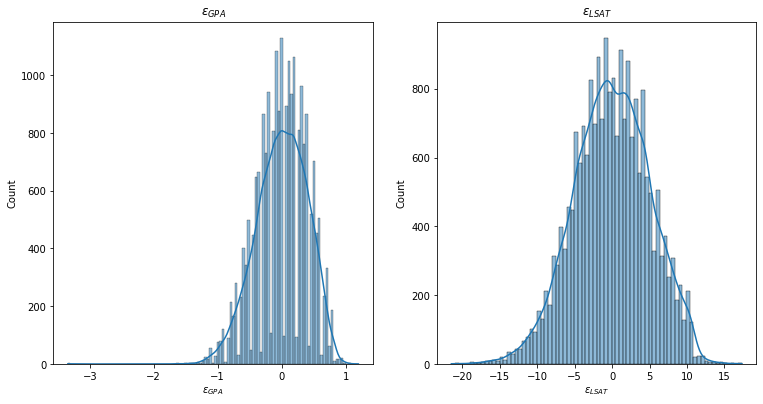

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

from plotutils import *

plt.subplot(1, 2, 1)
sns.histplot(epsilons_gpa, kde=True)
plt.title("$\epsilon_{GPA}$")
plt.xlabel("$\epsilon_{GPA}$")

plt.subplot(1, 2, 2)
sns.histplot(epsilons_LSAT, kde=True)
plt.title("$\epsilon_{LSAT}$")
plt.xlabel("$\epsilon_{LSAT}$")
plt.show()

We finally use the calculated $\epsilon$ to train a model in order to predict `FYA`.
We start by getting the subset of the $\epsilon$ which match the training indices.

In [46]:
X = np.hstack(
    (
        np.array(epsilons_gpa[df_train.index]).reshape(-1, 1),
        np.array(epsilons_LSAT[df_train.index]).reshape(-1, 1),
    )
)
X

array([[-0.24179687,  1.7890625 ],
       [ 0.15820312, -1.2109375 ],
       [ 0.55820312,  8.7890625 ],
       ...,
       [-0.44179688, -4.2109375 ],
       [-0.25087891, -4.7265625 ],
       [ 0.39980469,  1.31054688]])

In [47]:
linreg_fair_add = LinearRegression()

linreg_fair_add = linreg_fair_add.fit(
    X,
    df_train["ZFYA"],
)

We now use this model to calculate the predictions

In [54]:
X_test = np.hstack(
    (
        np.array(epsilons_gpa[df_test.index]).reshape(-1, 1),
        np.array(epsilons_LSAT[df_test.index]).reshape(-1, 1),
    )
)

predictions_fair_add = linreg_fair_add.predict(X_test)
predictions_fair_add

array([-0.04394693,  0.24454891,  0.35558793, ..., -0.38844376,
        0.06136776,  0.01295201])

And as previously, we calculate the model's score:

In [55]:
fair_add_score = linreg_fair_add.score(X_test, df_test["ZFYA"])
print(fair_add_score)

0.04475841449183948


In [57]:
RMSE_fair_add = np.sqrt(mean_squared_error(df_test["ZFYA"], predictions_fair_add))
print(RMSE_fair_add)

0.9065835039365202


## Comparison

The score so far are:

In [59]:
print(f"Unfair score:\t{score_unfair}")
print(f"FTU score:\t{ftu_score}")
print(f"L2 score:\t{latent_score}")
print(f"Fair add score:\t{fair_add_score}")

Unfair score:	0.12701634112845117
FTU score:	0.0917442226187073
L2 score:	0.0067887409029733226
Fair add score:	0.04475841449183948


In [60]:
print(f"Unfair RMSE:\t{RMSE_unfair}")
print(f"FTU RMSE:\t{RMSE_ftu}")
print(f"L2 RMSE:\t{RMSE_latent}")
print(f"Fair add RMSE:\t{RMSE_fair_add}")

Unfair RMSE:	0.8666709890234552
FTU RMSE:	0.8840061503773576
L2 RMSE:	0.9244257176167182
Fair add RMSE:	0.9065835039365202


## References

```{bibliography} ./references.bib
:filter: docname in docnames
```